In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import simplify_logic

from deep_logic.utils.base import validate_network
from deep_logic.utils.relunn import get_reduced_model, prune_features
from deep_logic import fol
import deep_logic as dl

torch.manual_seed(0)
np.random.seed(0)

In [2]:
x_train = pd.read_csv('dsprites/dsprites_c_train.csv', index_col=0)
y_train = pd.read_csv('dsprites/dsprites_y_train.csv', index_col=0)
x_test = pd.read_csv('dsprites/dsprites_c_test.csv', index_col=0)
y_test = pd.read_csv('dsprites/dsprites_y_test.csv', index_col=0)

In [3]:
base_concepts = ['color', 'shape', 'scale', 'rotation', 'x_pos', 'y_pos']
base_concepts

['color', 'shape', 'scale', 'rotation', 'x_pos', 'y_pos']

In [4]:
colors = ['white']
shapes = ['square', 'ellipse', 'heart']
scale = ['very small', 'small', 's-medium', 'b-medium', 'big', 'very big']
rotation = ['0°', '5°', '10°', '15°', '20°', '25°', '30°', '35°']
x_pos = ['x0', 'x2', 'x4', 'x6', 'x8', 'x10', 'x12', 'x14', 'x16', 'x18', 'x20', 'x22', 'x24', 'x26', 'x28', 'x30']
y_pos = ['y0', 'y2', 'y4', 'y6', 'y8', 'y10', 'y12', 'y14', 'y16', 'y18', 'y20', 'y22', 'y24', 'y26', 'y28', 'y30']
concepts = colors + shapes + scale + rotation + x_pos + y_pos

In [5]:
x_train = torch.tensor(x_train.values, dtype=torch.float)
x_test = torch.tensor(x_test.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([20993, 50])
torch.Size([5530, 50])
torch.Size([5530, 18])


In [6]:
# y_train = torch.zeros((y_train.shape[0], y_train.shape[1]), dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
print(y_train.shape)
n_classes = y_train.size(1)
print(n_classes)
y_train.sum(dim=0)

torch.Size([20993, 18])
18


tensor([1167., 1173., 1163., 1170., 1179., 1161., 1164., 1194., 1189., 1164.,
        1149., 1199., 1194., 1159., 1121., 1140., 1112., 1195.])

In [13]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x_train = x_train.to(device)
y_train = y_train.to(device)

layers = [
    torch.nn.Linear(x_train.size(1), 20 * n_classes),
    torch.nn.ReLU(),
    dl.nn.XLinear(20, 10, n_classes),
    torch.nn.ReLU(),
    dl.nn.XLinear(10, 5, n_classes),
    torch.nn.ReLU(),
    dl.nn.XLinear(5, 1, n_classes),
    torch.nn.Softmax(),
]
model = torch.nn.Sequential(*layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_form = torch.nn.BCELoss()
model.train()
need_pruning = True
for epoch in range(6000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x_train)
    # Compute Loss
    loss = loss_form(y_pred, y_train)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.0001 * torch.norm(module.weight, 1)
            loss += 0.0001 * torch.norm(module.bias, 1)
            break

    # backward pass
    loss.backward()
    optimizer.step()
    
    if epoch > 3000 and need_pruning:
        prune_features(model, n_classes, device)
        need_pruning = False

    # compute accuracy
    if epoch % 500 == 0:
        y_pred_d = torch.argmax(y_pred, dim=1)
        y_train_d = torch.argmax(y_train, dim=1)
        accuracy = y_pred_d.eq(y_train_d).sum().item() / y_train.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')


Epoch 0: train accuracy: 0.0554
Epoch 500: train accuracy: 1.0000
Epoch 1000: train accuracy: 1.0000
Epoch 1500: train accuracy: 1.0000
Epoch 2000: train accuracy: 1.0000
Epoch 2500: train accuracy: 1.0000
Epoch 3000: train accuracy: 1.0000
Epoch 3500: train accuracy: 1.0000
Epoch 4000: train accuracy: 1.0000
Epoch 4500: train accuracy: 1.0000
Epoch 5000: train accuracy: 1.0000
Epoch 5500: train accuracy: 1.0000


# Local explanations

In [15]:
x_test = x_test.to(device)
y_test = y_test.to(device)
np.set_printoptions(precision=2, suppress=True)
outputs = []
for i, (xin, yin) in enumerate(zip(x_test, y_test)):
    model_reduced = get_reduced_model(model, xin).to(device)
    for module in model_reduced.children():
        if isinstance(module, torch.nn.Linear):
            wa = module.weight.cpu().detach().numpy()
            break
    output = model_reduced(xin)
    
    pred_class = torch.argmax(output)
    true_class = torch.argmax(y_test[i])

    # generate local explanation only if the prediction is correct
    #if pred_class.eq(true_class):
    local_explanation = fol.relunn.explain_local(model, x_test, y_test, xin, true_class, True,
                                                 True, concepts, device)
    print(f'Input {(i+1)}')
    print(f'\tx={xin.cpu().detach().numpy()}')
    print(f'\ty={y_train[i].cpu().detach().numpy()}')
    print(f'\ty={output.cpu().detach().numpy()}')
    #print(f'\tw={wa}')
    print(f'\tExplanation: {local_explanation}')
    print()
    outputs.append(output)
    if i > 1:
        break

Input 1
	x=[1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.]
	y=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	y=[0.03 0.28 1.   0.98 1.   0.   0.   0.   0.   0.2  0.   0.   0.   0.38
 0.01 0.   0.99 0.  ]
	Explanation: square & very small

Input 2
	x=[1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]
	y=[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	y=[0.   0.   0.98 1.   1.   0.   0.   0.57 0.   0.45 0.   0.   0.   0.38
 0.01 0.   0.99 0.  ]
	Explanation: ellipse & very small

Input 3
	x=[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
	y=[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	y=[0.   0.   0.98 1.   1.   0.   0.06 0.   0.   0.2  0.01 0.   0

# Combine local explanations

In [19]:
global_explanation, predictions, counter = fol.combine_local_explanations(model, 
                                                                          x=x_train, y=y_train,
                                                                          is_pruned=True,
                                                                          target_class=0,
                                                                          topk_explanations=1,
                                                                          device=device)

In [20]:
accuracy, preds = fol.base.test_explanation(global_explanation, 0, x_test, y_test)
final_formula = fol.base.replace_names(global_explanation, concepts)
print(f'Accuracy when using the formula "{final_formula}": {accuracy:.4f}\n')

Accuracy when using the formula "square & very small": 1.0000



In [23]:
y_train_d = torch.argmax(y_train, dim=1)
for i, target_class in enumerate(range(n_classes)):
    global_explanation, predictions, counter = fol.combine_local_explanations(model, x=x_train, y=y_train, 
                                                                              is_pruned=True,
                                                                              target_class=target_class,
                                                                              topk_explanations=2,
                                                                              device=device)
    if global_explanation:
        accuracy, preds = fol.base.test_explanation(global_explanation, target_class, x_test, y_test)
        final_formula = fol.base.replace_names(global_explanation, concepts)
        print(f'Class {target_class} - Global explanation: "{final_formula}" - Accuracy: {accuracy:.4f}')

Class 0 - Global explanation: "square & very small" - Accuracy: 1.0000
Class 1 - Global explanation: "square & small" - Accuracy: 1.0000
Class 2 - Global explanation: "square & s-medium" - Accuracy: 1.0000
Class 3 - Global explanation: "square & b-medium" - Accuracy: 1.0000
Class 4 - Global explanation: "square & big" - Accuracy: 1.0000
Class 5 - Global explanation: "very big & ~ellipse" - Accuracy: 0.9492
Class 6 - Global explanation: "ellipse & very small" - Accuracy: 1.0000
Class 7 - Global explanation: "ellipse & small" - Accuracy: 1.0000
Class 8 - Global explanation: "ellipse & s-medium" - Accuracy: 1.0000
Class 9 - Global explanation: "ellipse & b-medium" - Accuracy: 1.0000
Class 10 - Global explanation: "ellipse & big" - Accuracy: 1.0000
Class 11 - Global explanation: "ellipse & very big & ~square" - Accuracy: 1.0000
Class 12 - Global explanation: "heart & very small" - Accuracy: 1.0000
Class 13 - Global explanation: "heart & small" - Accuracy: 1.0000
Class 14 - Global explanati

Accuracy: 1.0000


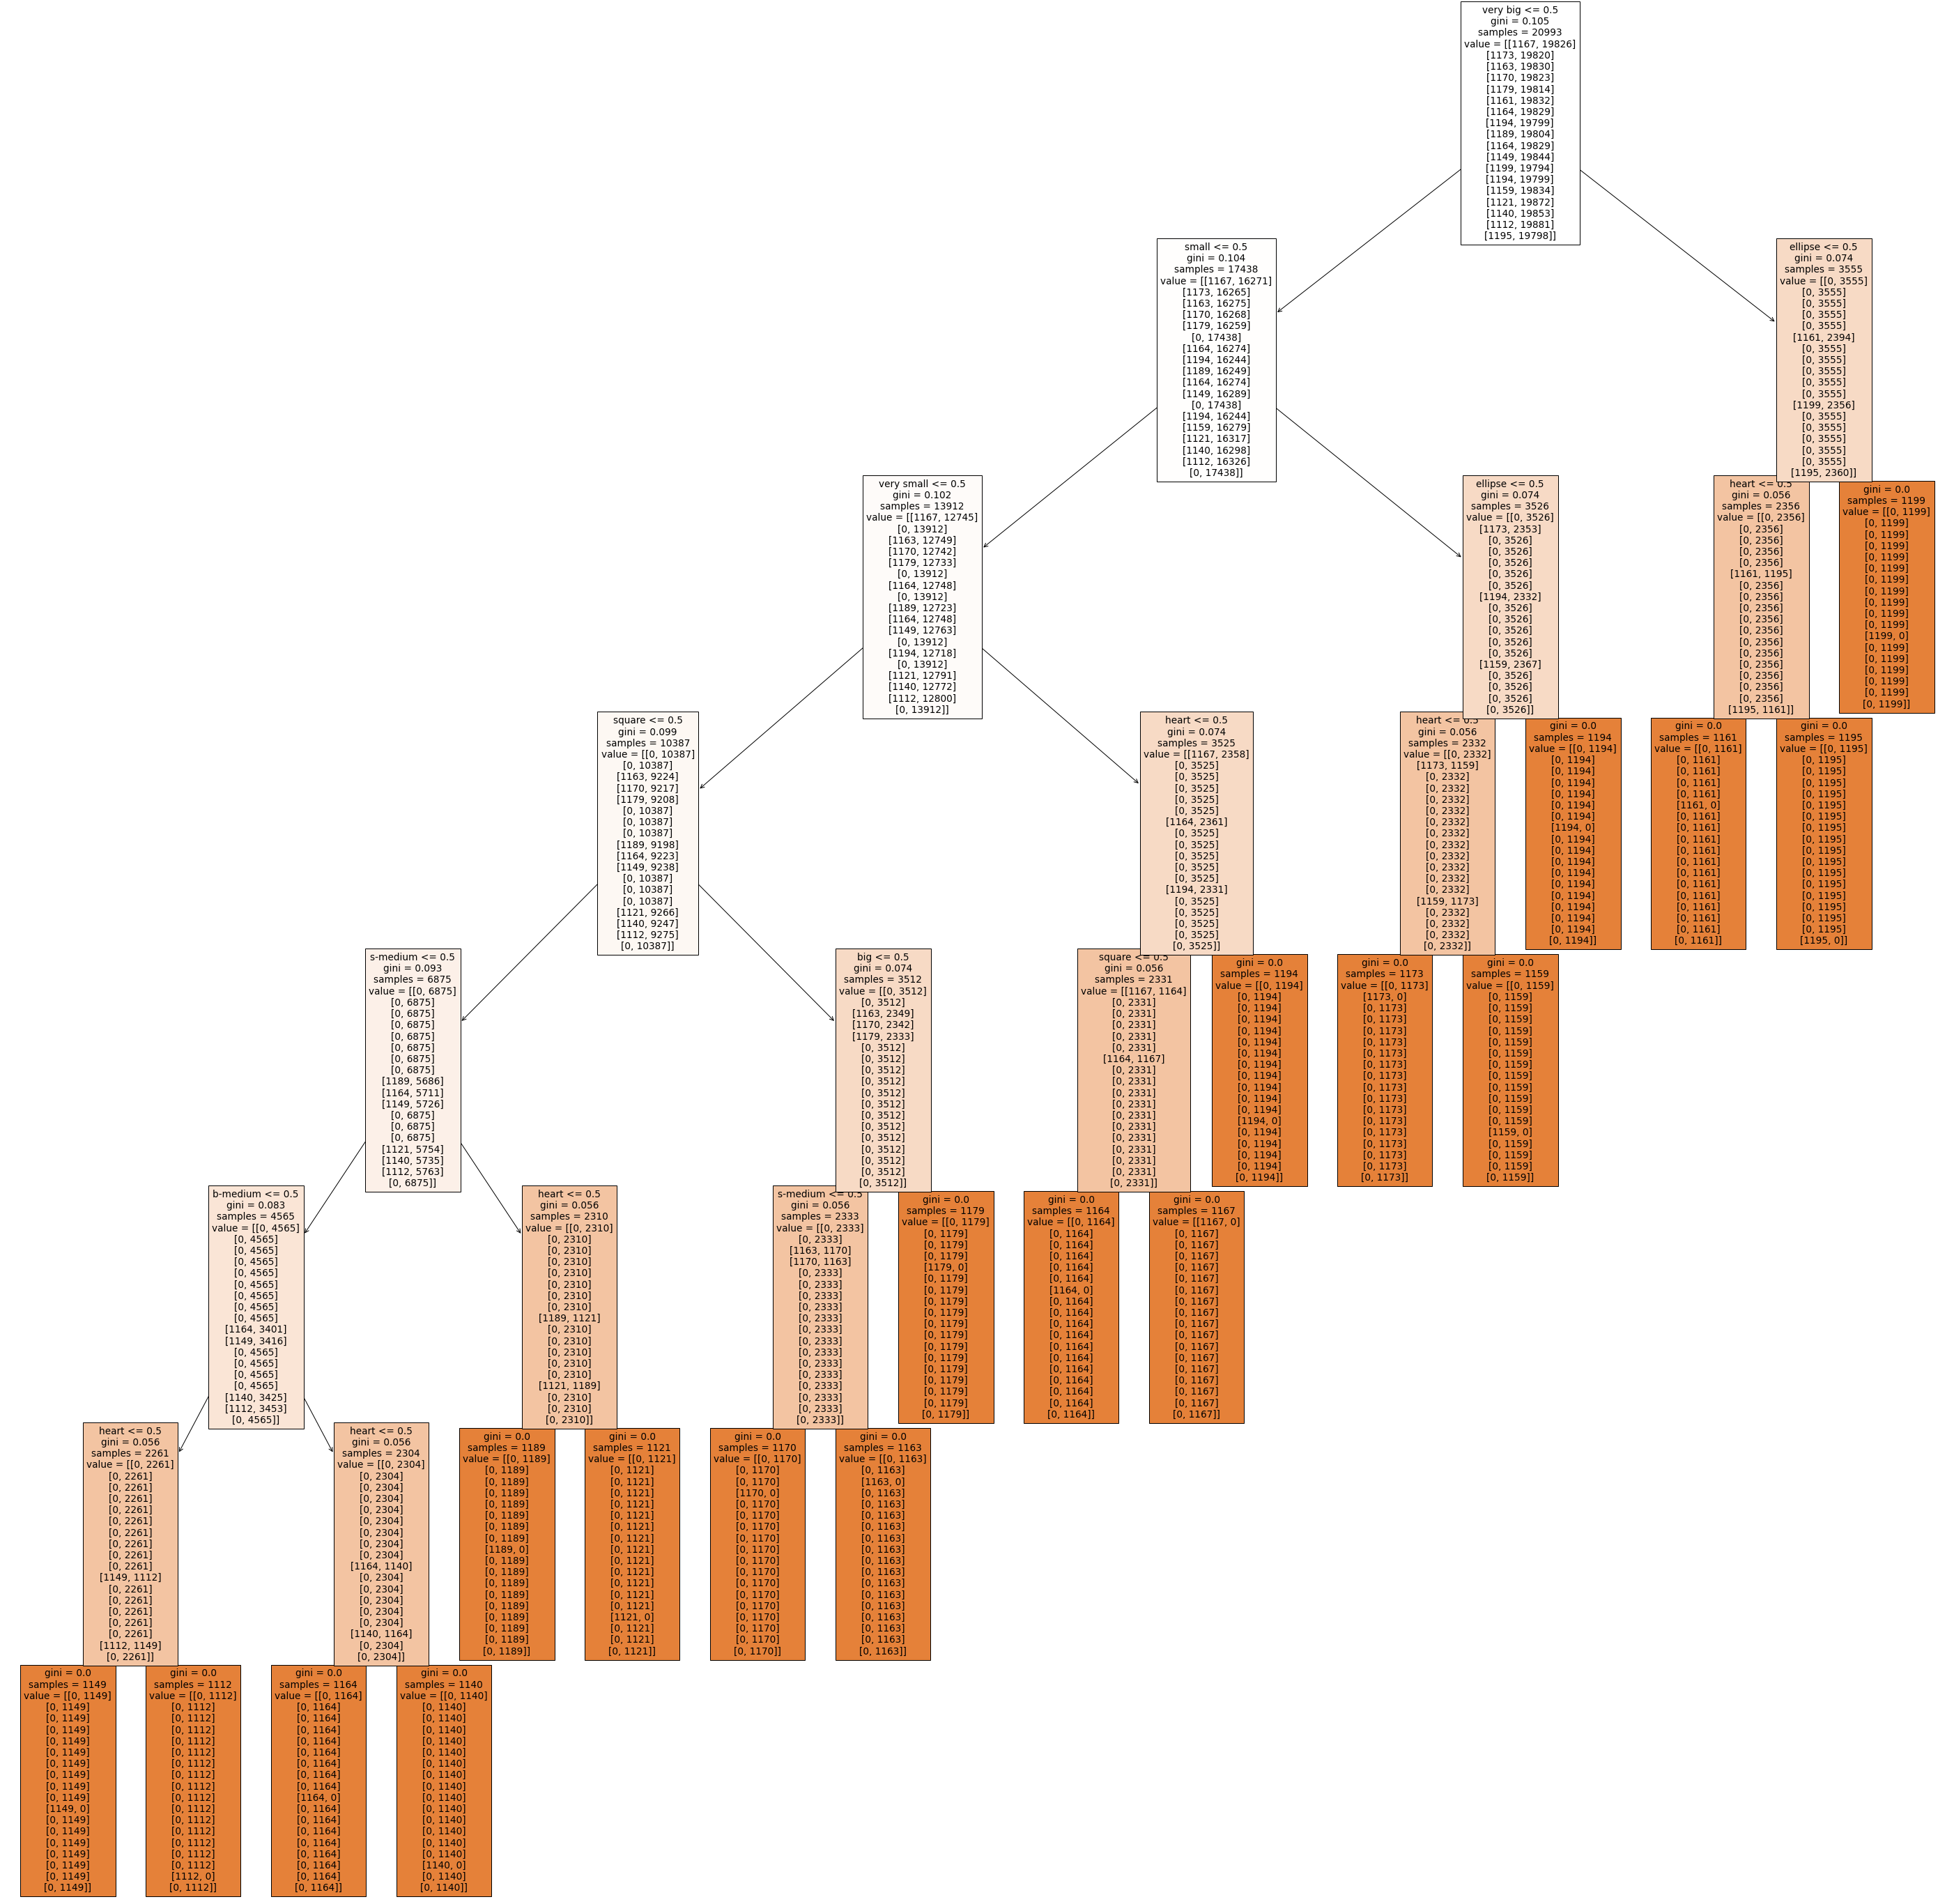

In [43]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy()==0)
y_preds = classifier.predict(x_test.cpu().detach().numpy())
accuracy = accuracy_score(y_test.cpu().detach().numpy()==0, y_preds)
print(f'Accuracy: {accuracy:.4f}')

plt.figure(figsize=[50, 50])
plot_tree(classifier, feature_names=concepts, filled=True)
plt.savefig('dsprites.png')
plt.show()

In [24]:
y_train_d = torch.argmax(y_train, dim=1)
for target_class in range(n_classes):
    global_explanation = fol.explain_global(model, n_classes, 
                                            target_class=target_class, 
                                            concept_names=concepts, device=device)

    explanation = fol.relunn.explain_global(model, n_classes, target_class, device=device)
    if explanation not in ['False', 'True', 'The formula is too complex!']:
        accuracy, _ = fol.relunn.test_explanation(explanation, target_class, x_train.cpu(), y_train.cpu())
        print(f'Class {target_class} - Global explanation: "{global_explanation}" - Accuracy: {accuracy:.4f}')

Class 0 - Global explanation: "very small" - Accuracy: 0.8877
Class 1 - Global explanation: "square & small" - Accuracy: 1.0000
Class 2 - Global explanation: "s-medium" - Accuracy: 0.8900
Class 3 - Global explanation: "square & b-medium" - Accuracy: 1.0000
Class 4 - Global explanation: "square | ~big" - Accuracy: 0.1639
Class 5 - Global explanation: "very big & ~ellipse" - Accuracy: 0.9431
Class 6 - Global explanation: "ellipse & very small" - Accuracy: 1.0000
Class 7 - Global explanation: "small" - Accuracy: 0.8889
Class 8 - Global explanation: "ellipse & s-medium" - Accuracy: 1.0000
Class 9 - Global explanation: "ellipse & b-medium" - Accuracy: 1.0000
Class 10 - Global explanation: "ellipse & big" - Accuracy: 1.0000
Class 11 - Global explanation: "(ellipse & very big) | (ellipse & ~square)" - Accuracy: 0.7209
Class 12 - Global explanation: "heart & very small" - Accuracy: 1.0000
Class 13 - Global explanation: "heart & small" - Accuracy: 1.0000
Class 14 - Global explanation: "heart & 